# Create travel time grid with Pykonal 
more info in original publication : DOI: 10.1785/0220190318 <br>
https://www.researchgate.net/publication/341889419_PyKonal_A_Python_Package_for_Solving_the_Eikonal_Equation_in_Spherical_and_Cartesian_Coordinates_Using_the_Fast_Marching_Method <br>
Pykonal documentation : https://malcolmw.github.io/pykonal-docs/index.html

In [1]:
# standard data handling 
import numpy as np
import pandas as pd
import xarray as xr
# create progress bar 
from tqdm import tqdm
# plot
from matplotlib import pyplot as plt
# Convert UTM to other projection
import utm
# Ray tracing tool 
import pykonal
from pykonal.transformations import geo2sph


## 1) Load Velocity model 

Velocity model dimensions <br>
depth : in positive number of km (ie 5 km depth = 5, 200m above sea level = -0.2)<br>
sea level = earth radius 6371 km <br>
latitude : ° N <br>
longitude : in ° E


### 3D model from .CSV file 
Projection : spherical  

In [2]:
path_velocity_model = r''

df = pd.read_csv(path_velocity_model, sep = ',')

# Spherical projection 
df = df.rename(columns={'Z(m)': "depth", 'V(km/s)': 'Vs'})
lon_min = np.full(df.index.values.shape, min(df['X_UTM(m)'].values))
lat_min = np.full(df.index.values.shape, min(df['Y_UTM(m)'].values))
df['latitude'] = utm.to_latlon(lon_min, df['Y_UTM(m)'].values, 28,'R')[0]
df['longitude'] = utm.to_latlon( df['X_UTM(m)'].values, lat_min, 28,'R')[1]

# get epth in km 
df['depth'] = -df['depth']/1000

# Convert DataFrame to an xarray Dataset
ds = df.set_index(['latitude','longitude' ,'depth' ]).to_xarray()

# Extract the velocity as a DataArray
velocity_model = ds['Vs']

# If velocity model has no values above topography 
# extrude model upward to have all station within data domain 

fill_limit = 6  # Maximum number of times a NaN can be replaced
# Create a counter array to track the number of times a NaN is replace

test = velocity_model.values[::, ::, ::-1]
fill_count = np.zeros_like(test, dtype=int)

for depth_slice in range(1, test.shape[2]):
    old_slice = test[:, :, depth_slice - 1]
    new_slice = test[:, :, depth_slice]
    
    # Create a mask for NaN values that have been replaced less than twice
    mask = np.isnan(new_slice) & (fill_count[:, :, depth_slice] < fill_limit)
    
    # Replace values where the mask is True
    test[:, :, depth_slice][mask] = old_slice[mask]
    
    # Update the fill count for those replaced values
    fill_count[:, :, depth_slice:][mask] += 1

velocity_model.values = test[::, ::, ::-1]


velocity_model.isel(depth =5).plot()




FileNotFoundError: [Errno 2] No such file or directory: ''

### 1D model from .CSV file 
projection : spherical

In [3]:
FILEPATH_VELOCITY = r""

depths = np.linspace(-2, 5, 100)
latitudes = np.linspace(63.81810, 64.03551,100)
longitudes = np.linspace(-22.62691, -21.94679, 100)

phase = 'Vs'

velocity_layers = pd.read_csv(
    FILEPATH_VELOCITY,
    usecols=[0, 3],
    names=["depth", 'Vs'],
    skiprows=1,
    index_col="depth",
    )

smoothing_window = 4

FileNotFoundError: [Errno 2] No such file or directory: ''

In [4]:


# quick visualisation
velocity_layers.T

velocity_layers_interp = velocity_layers.reindex(depths, method="ffill")
padded_data = np.pad(velocity_layers_interp[phase].values, pad_width=smoothing_window//2, mode='edge')

# smoothing on model
if smoothing_window %2 != 0:
    velocity_layers_interp[phase] = np.convolve(padded_data, np.ones(smoothing_window)/smoothing_window, mode = 'valid')[:]
if smoothing_window %2 == 0:
    velocity_layers_interp[phase] = np.convolve(padded_data, np.ones(smoothing_window)/smoothing_window, mode = 'valid')[:-1]
velocity_layers.plot(drawstyle="steps-post")
velocity_layers_interp.sort_values("depth").plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model",
    ax=plt.gca(),
    grid=True,
    figsize=(7.5, 6),
    marker="s",
    ls=""
)
plt.axvspan(depths.min(), depths.max(), alpha=0.2) # Labels and legends
#plt.legend(["P", "S", "P interpolated", "S interpolated", "Domain"])
plt.show()
#### La Palma

velocities = velocity_layers_interp.stack().to_xarray()
velocities = velocities.rename({"level_1": "phase"})
velocities = velocities.sel(phase = phase)
velocity_model = velocities.expand_dims(latitude=latitudes, longitude=longitudes)

NameError: name 'velocity_layers' is not defined

### Homogeneous velocity model
projection : spherical

In [10]:
C = 1 # km/s

depths = np.linspace(-2, 5, 100)
latitudes = np.linspace(63.85923, 63.91461,100)
longitudes = np.linspace(-22.33035, -22.20656, 100)


In [11]:
# Create a 3D array filled with the value C
data = np.full((len(depths), len(latitudes), len(longitudes)), C)

# Create the DataArray
velocity_model = xr.DataArray(
    data,
    coords={
        "depth": depths,
        "latitude": latitudes,
        "longitude": longitudes
    },
    dims=["depth", "latitude", "longitude"],
    name="velocity"
)

## 2) Resample Model 

Insure that the model has homogeneous spacing along dimension. <br> 
Increasing the resolution can give better results. The travel time grid can be downsampeled later in the Notebook

In [12]:
### resample velocity grid ###
n_lat_sample = 100 # number of lat sample for new grid 
n_lon_sample = 101 # number of lon sample for new grid 
n_dep_sample = 102 # number of sample for new depth grid 

lat_ratio = velocity_model.coords['latitude'].shape[0]/n_lat_sample
lon_ratio = velocity_model.coords['longitude'].shape[0]/n_lon_sample
dep_ratio = velocity_model.coords['depth'].shape[0]/n_dep_sample

### CORE ###
new_lat = np.linspace(velocity_model.coords['latitude'][0], velocity_model.coords['latitude'][-1], n_lat_sample)
new_lon = np.linspace(velocity_model.coords['longitude'][0], velocity_model.coords['longitude'][-1], n_lon_sample)
new_dep = np.linspace(velocity_model.coords['depth'][0], velocity_model.coords['depth'][-1], n_dep_sample)

velocity_model = velocity_model.interp(latitude = new_lat, longitude = new_lon, depth = new_dep, method='linear')


Orient velocity data so when we extract them in an array to create traveltime grid they are not flipped

In [13]:
# Orientation of the grid 
# The reference point (corner top left at the bottom of the grid) is a max or a min value of the axis? 
# Allows to give correct orientation of the grid and avoid flipping during computation.


ref_lon = 'min'
ref_lat = 'max'
ref_depth = 'max'

# Ensure coordinates are in descending order
if velocity_model.latitude.values[0] > velocity_model.latitude.values[-1] and ref_lat == 'min' :
    velocity_model = velocity_model.sortby("latitude", ascending=True)
if velocity_model.latitude.values[0] < velocity_model.latitude.values[-1] and ref_lat == 'max' :
    velocity_model = velocity_model.sortby("latitude", ascending=False)

if velocity_model.longitude.values[0] > velocity_model.longitude.values[-1] and ref_lon == 'min' :
    velocity_model = velocity_model.sortby("longitude", ascending=True)
if velocity_model.longitude.values[0] < velocity_model.longitude.values[-1] and ref_lon == 'max' :
    velocity_model = velocity_model.sortby("longitude", ascending=False)

if velocity_model.depth.values[0] > velocity_model.depth.values[-1] and ref_depth == 'min' :
    velocity_model = velocity_model.sortby("depth", ascending=True)
if velocity_model.depth.values[0] < velocity_model.depth.values[-1] and ref_depth == 'max' :
    velocity_model = velocity_model.sortby("depth", ascending=False)


## Quick visualisation to see if it make sens

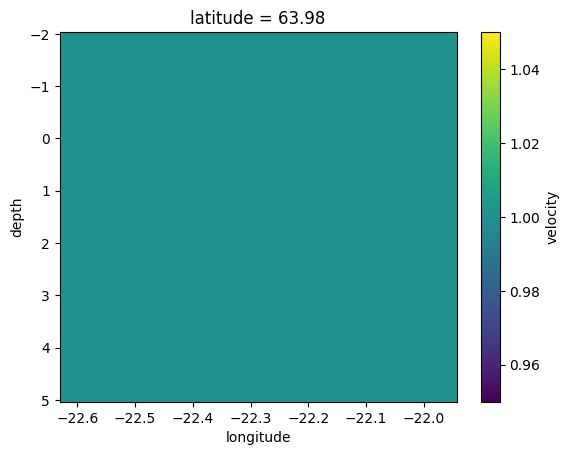

In [14]:
velocity_model.isel(latitude =25).plot(x = 'longitude')
plt.gca().invert_yaxis()

## 3) Load station information

Change STATION_ENTRIES to match your CSV header <br>
The depth of your station must be in km with 0 at sea level. Negative depth values are positive altitude (i.e. depth = -2 means the staion is at 2km above sea level)<br>
The index of the pandas dataframe must be the station name (it will be used to name the traveltime grid in the xr.Dataset) 

In [18]:
### path to station info ###
station_info_path = r'C:\Users\liliv\Desktop\Fagradalfjall\Tremor_loc\Velocity model\station_fagra.csv'
station_info = pd.read_csv(station_info_path, sep = ',', index_col =0)
print(station_info.tail())
STATION_ENTRIES = ["lat", "lon", "alt"] # order = lat, lon, dep



            lat        lon  altitude     alt  angle  dip  distance_along_fiber
Name                                                                          
odf   63.946900 -22.119000        60 -0.0060      0   90                     0
rah   63.852855 -22.567946        51 -0.0051      0   90                     0
sgi   63.863371 -22.329210       177 -0.0177      0   90                     0
vatn  63.872700 -22.374300        80 -0.0080      0   90                     0
vog   63.969670 -22.392850         7 -0.0007      0   90                     0


## 4) Calculate travel time SPHERICAL 
!!! Velocity model with SPHERICAL coordinates !!!

### Issues and trouble shooting 


1) the model run but the location of the station (min travel time) is not correct. <br>
This can be caused by the traveltime gid beeing extracted from the xarray in the wrong orientation. Must verify that step 2 is well filled <br>
i.e. is the reference point a min or a max in lat, lon depth

2) if all values are np.inf in travel time grid <br>it could be caused by the source being defined outside of the model's grid (verify of source parameters, the classic is depth express in meters when pykonals takes km and / or grid dimensions)

3. To verify that all parameters are set correctly, one can run a grid with velocities of 1km/s with a source at the grid origin: <br>
solver.src_loc = reference_point <br>
The time in second at the edges should equal the dimensions in km of the grid 

### Model dimensions and reference points
==> reference point = lowest, northest, eastest point of the model. <br>
==> node interval = distance between adjacent  nodes for: depth from sea level (km), latitude (radians), longitude (radians) [sperical model]

In [19]:
### CREATE MODEL REFERENCE ### 

# ==>   reference_point = lowest, northest, eastest point of the model.
# ==>   depth, lat, lon =  geo2sph((lat, lon, depth)).

latitudes = velocity_model.coords['latitude'].values
longitudes = velocity_model.coords['longitude'].values
depths = velocity_model.coords['depth'].values
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
print(reference_point)

# ==> node_interval = distance between adjacent  nodes for: depth (m), latitude (radians), longitude (radians).
# ==> The units for nodal distance are m,rad,rad for spherical model but becoms m, m, m for carteian model
# ==> !!! lat and lon in radians because model in spherical coordinates (mandatory for PointSourceSolver) otherwise can create a cartesian model, then units are not the same.

node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.deg2rad(np.abs(latitudes[1] - latitudes[0])),
    np.deg2rad(np.abs(longitudes[1] - longitudes[0])),
)
print(node_intervals)

[ 6.36600000e+03  4.53165839e-01 -3.94914079e-01]
(0.06930693069306848, 3.832848814921764e-05, 0.00011870333308666851)


### Computation

In [ ]:
# transpose velocity model to go from lat lon depth to depth lat lon
velocities = velocity_model.transpose( 'depth','latitude', 'longitude').copy()
# container to keep travel time grids 
ttime_ds = xr.Dataset( coords=velocity_model.coords)

for Station_Name in tqdm(station_info.index):

    ### Create and run model ###
    solver = pykonal.solver.PointSourceSolver(coord_sys="spherical")
    solver.velocity.min_coords = reference_point
    solver.velocity.node_intervals = node_intervals
    solver.velocity.npts = velocities.values.shape
    solver.velocity.values = velocities.values

    # Initialize the source location with a random location within the
    # computational grid.
    # Source
    src_loc = station_info.loc[Station_Name][STATION_ENTRIES].values
    solver.src_loc = np.array(geo2sph(src_loc).squeeze()) # 

    # Compute traveltimes.
    solver.solve()

    tt = solver.tt.values

    travel_times = velocities.copy()
    travel_times.values  = tt
    travel_times = travel_times.transpose('latitude', 'longitude', 'depth')

    values = travel_times.values
    values = np.where(np.abs(values) > 1e10, np.nan, values)
    values[np.isinf(values)] = np.nan
    data_array = xr.DataArray(values, dims = travel_times.dims, coords=travel_times.coords)
    ttime_ds[str(Station_Name)] = data_array

100%|██████████| 22/22 [02:08<00:00,  5.82s/it]


## Quick visualisation to see if it make sens

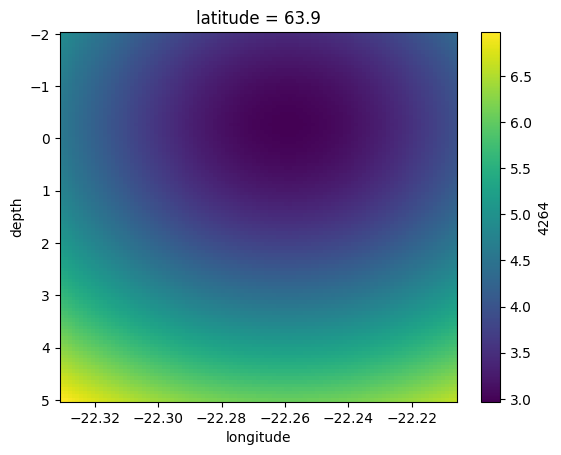

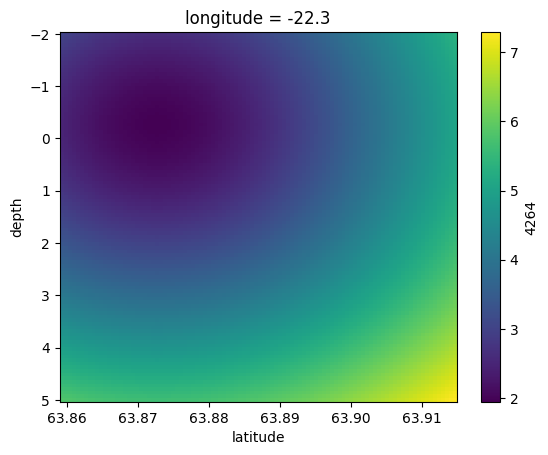

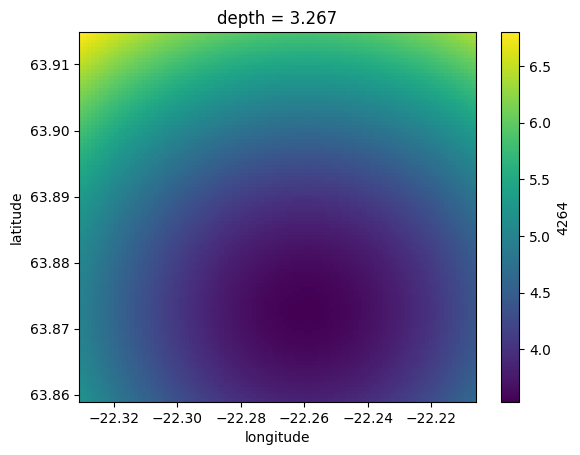

In [ ]:
# change slice index in isel() to moove them in the grid 
station = ''

ttime_ds[station].isel(latitude = 27).plot(x = 'longitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(longitude = 25).plot(x = 'latitude')
plt.gca().invert_yaxis()
plt.show()
ttime_ds[station].isel(depth = 25).plot(x = 'longitude')

## 5) Save ttime grids in h5 format 

resample the travel time grid to reduce computational time for the task that uses the grid 

In [ ]:
### resample travel time grid before saving if needed ###


n_lat_sample = 100 # number of lat sample for new grid 
n_lon_sample = 101 # number of lon sample for new grid 
n_dep_sample = 102 # number of sample for new depth grid 

lat_ratio = ttime_ds.coords['latitude'].shape[0]/n_lat_sample
lon_ratio = ttime_ds.coords['longitude'].shape[0]/n_lon_sample
dep_ratio = ttime_ds.coords['depth'].shape[0]/n_dep_sample

### CORE ###
new_lat = np.linspace(ttime_ds.coords['latitude'][0], ttime_ds.coords['latitude'][-1], n_lat_sample)
new_lon = np.linspace(ttime_ds.coords['longitude'][0], ttime_ds.coords['longitude'][-1], n_lon_sample)
new_dep = np.linspace(ttime_ds.coords['depth'][0], ttime_ds.coords['depth'][-1], n_dep_sample)

ttime_ds = ttime_ds.interp(latitude = new_lat, longitude = new_lon, depth = new_dep, method='linear')

Keep only a subset of the map to reduce next step computational cost 

In [ ]:
############### SUBSET ######################

# Suppose your dataset is called ds and the variable is "traveltime"
depth_new = np.linspace(-2, 1, 30)
lat_new = np.linspace(63.85923, 63.91461,50)
lon_new = np.linspace(-22.33035, -22.20656, 50)

# Build the target grid
target_grid = {
    "latitude": lat_new,
    "longitude": lon_new,
    "depth": depth_new
}

# Interpolate onto the target grid
ttime_ds = ttime_ds.interp(target_grid)

Save file as a dataset containing all travel time grids 

In [ ]:
saving_folder= r''
file_name = ''

ttime_ds.to_netcdf(saving_folder+'\\'+file_name+'.h5')